# Capstone 3 - Data pre-processing

### Table of contents

* [Introduction](#intro)
    * [Import relevant libraries](#import)
    * [Retrieve variables](#retrieve-variables)
* [Preparing to pre-process the data](#prepare-preprocess)
    * [Define a function `identify_missing_values`](#missing-values)
    * [Define a function `knn_impute`](#knn-impute)
* [Imputing missing values](#impute)
    * [Summary data](#impute-summary)
    * [Lower grades achievement data](#impute-lg-achievement)
    * [High school achievement data](#impute-hs-achievement)
* [Machine learning model: K-Means clustering](#machine-learning-model)
    * [Silhouette score](#silhouette-score)
    * [Noise characteristics heatmap for each cluster](#noise-cluster-heatmap)
    * [Academic performance by cluster](#academic-performance)
    * [Cluster visualization](#cluster-visualization)
    * [Feature importance](#feature-importance)

## Introduction <a name="intro"></a>

### Import relevant libraries <a name="import"></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import folium
import branca.colormap as cm

### Retrieve variables <a name="retrieve-variables"></a>

In [2]:
# Retrieve original noise_data dataframe
%store -r noise_data

# Retrieve GeoPandas dataframes
%store -r districts_gdf 
%store -r schoolpoints_gdf

# Retrieve schools covered by sensor range
%store -r coverage_matrix

# Retrieve school demographic information
%store -r combined_summary_df

# Retrieve lower grades achievement information
%store -r combined_lg_achievement_df

# Retrieve high school achievement information
%store -r combined_hs_achievement_df

# # Retrieve combined achievement data
# %store -r coverage_combined_achievement_df
# %store -r non_coverage_combined_achievement_df

# # Retrieve merged dataset with all metrics
# %store -r merged_coverage_df

# Retrieve school lists
%store -r elem_middle_schools
%store -r high_schools
%store -r filtered_schools

In [3]:
# For machine learning model
# Retrieve school patterns
%store -r school_patterns_df

## Preparing to pre-process the data <a name="prepare-preprocess"></a>

To simplify our pre-processing stage, we will write a few functions.

### Define a function `identify_missing_values` <a name="missing-values"></a>
To start, we will define a function, `identify_missing_values`, that will help us isolate columns with missing values.

In [4]:
def identify_missing_values(df):
    # Isolate numerical variables
    numerical_variables = df.select_dtypes(exclude=['object', 'category', 'bool']).columns
    
    # Loop through numerical variables of summary dfs to find number of null values in each column
    # Also, create an empty list for adding any columns with missing values
    missing_numerical_variables = []
    for item in numerical_variables:
        missing_values = df[item].isnull().sum()
        if missing_values > 0:
            print(f"{item}: {missing_values}")
            missing_numerical_variables.append(item)
    
    return missing_numerical_variables

### Define a function `knn_impute` <a name="knn-impute"></a>

In [5]:
def knn_impute(df, n_neighbors=5):
    print(f"{'-'*80}\nMissing numerical variables before imputing:")
    missing_numerical_variables = identify_missing_values(df)
    print(f"{'-'*80}")
    missing_numerical_data = df[missing_numerical_variables]
    
    # Perform KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    numerical_data_imputed = imputer.fit_transform(missing_numerical_data)
    
    # Convert imputed data back to a dataframe
    numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=missing_numerical_variables, 
                                          index=df.index)
    
    # Combine with original categorical columns
    df_imputed = df.copy()
    df_imputed[missing_numerical_variables] = numerical_data_imputed
    
    return df_imputed

## Imputing missing values <a name="impute"></a>

### Summary data (`combined_summary_df`) <a name="impute-summary"></a>

In [6]:
combined_summary_imputed = knn_impute(combined_summary_df)
combined_summary_imputed

--------------------------------------------------------------------------------
Missing numerical variables before imputing:
student_attendance_rate: 98
chronic_absence_pct: 108
teacher_attendance_rate: 705
--------------------------------------------------------------------------------


0        DBN                                   school_name  enrollment  \
0     01M015                     P.S. 015 Roberto Clemente         161   
1     01M019                           P.S. 019 Asher Levy         247   
2     01M020                          P.S. 020 Anna Silver         499   
3     01M034                P.S. 034 Franklin D. Roosevelt         337   
4     01M064                         P.S. 064 Robert Simon         226   
...      ...                                           ...         ...   
5299  24Q550             High School for Arts and Business         812   
5300  28Q220                        P.S. 220 Edward Mandel         670   
5301  84M174    Success Academy Union Square (Manhattan 1)         619   
5302  84M202                     Great Oaks Charter School         215   
5303  84M330  Girls Preparatory Charter School of New York         654   

0     ell_pct  disability_pct  self_contained_pct  asian_pct  black_pct  \
0       0.075           0.304               0.031      0.068      0.298   
1       0.036           0.340               0.117      0.077      0.202   
2       0.186           0.224               0.072      0.329      0.098   
3       0.080           0.380               0.021      0.053      0.297   
4       0.044           0.354               0.009      0.058      0.190   
...       ...             ...                 ...        ...        ...   
5299    0.095           0.158               0.001      0.085      0.079   
5300    0.224           0.113               0.016      0.330      0.076   
5301    0.031           0.195               0.039      0.186      0.221   
5302    0.042           0.302               0.028      0.084      0.256   
5303    0.021           0.179               0.011      0.021      0.466   

0     hispanic_pct  white_pct  student_attendance_rate  chronic_absence_pct  \
0            0.584      0.025                 0.938000             0.215000   
1            0.664      0.053                 0.910000             0.324000   
2            0.491      0.042                 0.929000             0.256000   
3            0.614      0.030                 0.912000             0.305000   
4            0.673      0.071                 0.913000             0.346000   
...            ...        ...                      ...                  ...   
5299         0.765      0.054                 0.912000             0.249000   
5300         0.200      0.357                 0.944000             0.162000   
5301         0.258      0.283                 0.915104             0.267778   
5302         0.619      0.028                 0.915104             0.267778   
5303         0.465      0.018                 0.942000             0.152000   

0     teacher_attendance_rate academic_year  coverage grade_level  
0                    0.982000     2016-2017     False          lg  
1                    0.972000     2016-2017     False          lg  
2                    0.962000     2016-2017     False          lg  
3                    0.972000     2016-2017     False          lg  
4                    0.969000     2016-2017     False          lg  
...                       ...           ...       ...         ...  
5299                 0.965000     2018-2019      True          hs  
5300                 0.955000     2018-2019      True          lg  
5301                 0.963933     2018-2019      True          lg  
5302                 0.963933     2018-2019      True          lg  
5303                 0.963200     2018-2019      True          lg  

[5304 rows x 16 columns]

### Lower grades achievement data (`combined_lg_achievement_df`) <a name="impute-lg-achievement"></a>

In [7]:
combined_lg_achievemnet_imputed = knn_impute(combined_lg_achievement_df)
combined_lg_achievemnet_imputed

--------------------------------------------------------------------------------
Missing numerical variables before imputing:
achievement_score: 252
ela_proficient_pct: 12
ela_avg_proficiency: 12
ela_lowest_third_proficiency: 12
math_proficient_pct: 17
math_avg_proficiency: 17
math_lowest_third_proficiency: 17
attendance_90_plus_pct: 94
--------------------------------------------------------------------------------


0        DBN                                   school_name school_type  \
0     01M015                     P.S. 015 Roberto Clemente  Elementary   
1     01M019                           P.S. 019 Asher Levy  Elementary   
2     01M020                          P.S. 020 Anna Silver  Elementary   
3     01M034                P.S. 034 Franklin D. Roosevelt         K-8   
4     01M064                         P.S. 064 Robert Simon  Elementary   
...      ...                                           ...         ...   
3836  24Q014                             P.S. 014 Fairview  Elementary   
3837  28Q220                        P.S. 220 Edward Mandel  Elementary   
3838  84M174    Success Academy Union Square (Manhattan 1)  Elementary   
3839  84M202                     Great Oaks Charter School      Middle   
3840  84M330  Girls Preparatory Charter School of New York         K-8   

0     achievement_score  ela_proficient_pct  ela_avg_proficiency  \
0                 4.920               0.338                 2.67   
1                 4.230               0.486                 2.85   
2                 2.210               0.289                 2.52   
3                 2.890               0.254                 2.52   
4                 3.770               0.286                 2.56   
...                 ...                 ...                  ...   
3836              2.850               0.288                 2.52   
3837              2.050               0.468                 2.89   
3838              4.860               0.925                 3.75   
3839              3.658               0.261                 2.55   
3840              3.920               0.669                 3.23   

0     ela_lowest_third_proficiency  math_proficient_pct  math_avg_proficiency  \
0                             2.67                0.429                  2.79   
1                             2.35                0.481                  3.01   
2                             1.92                0.311                  2.52   
3                             2.04                0.177                  2.34   
4                             2.08                0.321                  2.54   
...                            ...                  ...                   ...   
3836                          1.94                0.324                  2.57   
3837                          1.99                0.480                  2.91   
3838                          3.48                0.977                  4.14   
3839                          2.11                0.311                  2.53   
3840                          2.68                0.601                  3.14   

0     math_lowest_third_proficiency  attendance_90_plus_pct  ela_proficient_n  \
0                              2.20                  0.7850                68   
1                              2.24                  0.6760               109   
2                              1.77                  0.7440               218   
3                              1.83                  0.6950               240   
4                              1.90                  0.6540               105   
...                             ...                     ...               ...   
3836                           1.82                  0.8170               877   
3837                           1.93                  0.8380               316   
3838                           3.92                  0.9110               305   
3839                           1.90                  0.6674               207   
3840                           2.34                  0.8480               432   

0     math_proficient_n  ela_lowest_third_n  math_lowest_third_n  \
0                    70                  19                   18   
1                   106                  24                   23   
2                   219                  44                   45   
3                   232                  74                   68   
4       

### High school achievement data (`combined_hs_achievement_df`) <a name="impute-hs-achievement"></a>

In [8]:
combined_hs_achievement_imputed = knn_impute(combined_hs_achievement_df)
combined_hs_achievement_imputed

--------------------------------------------------------------------------------
Missing numerical variables before imputing:
achievement_score: 93
grad_rate_4yr: 73
grad_rate_6yr: 206
regents_english: 28
regents_algebra: 91
regents_living_env: 137
regents_global: 151
regents_us_history: 166
college_prep_index: 74
college_ready_4yr: 74
college_ready_6yr: 206
postsec_enroll_6mo: 129
postsec_enroll_18mo: 206
credits_yr1: 35
credits_yr2: 53
credits_yr3: 66
attendance_90_plus_pct: 14
--------------------------------------------------------------------------------


0        DBN                                        school_name  school_type  \
0     01M292                         Orchard Collegiate Academy  High School   
1     01M448                University Neighborhood High School  High School   
2     01M509                            Marta Valle High School  High School   
3     01M539  New Explorations into Science, Technology and ...  High School   
4     01M696                     Bard High School Early College  High School   
...      ...                                                ...          ...   
1458  13K674  City Polytechnic High School of Engineering, A...  High School   
1459  14K610                             Automotive High School  High School   
1460  15K592                Khalil Gibran International Academy  High School   
1461  15K656                   Brooklyn High School of the Arts  High School   
1462  24Q550                  High School for Arts and Business  High School   

0     achievement_score  grad_rate_4yr  grad_rate_6yr  regents_english  \
0                  3.72          0.658          0.708             76.5   
1                  4.45          0.897          0.855             73.1   
2                  2.89          0.741          0.604             67.4   
3                  4.23          0.973          0.992             88.1   
4                  4.41          0.991          0.987             89.4   
...                 ...            ...            ...              ...   
1458               2.52          0.782          0.909             68.2   
1459               2.90          0.767          0.650             65.3   
1460               2.93          0.767          0.706             61.3   
1461               2.75          0.881          0.934             74.5   
1462               3.99          0.935          0.922             73.1   

0     regents_algebra  regents_living_env  regents_global  ...  credits_yr1  \
0                67.1               65.60            59.4  ...        0.868   
1                72.5               72.60            71.8  ...        0.945   
2                59.4               58.60            56.7  ...        0.862   
3                78.2               80.90            90.6  ...        0.913   
4                79.6               75.62            86.5  ...        0.950   
...               ...                 ...             ...  ...          ...   
1458             58.9               64.50            78.0  ...        0.835   
1459             59.2               65.70            60.8  ...        0.760   
1460             57.1               57.40            58.2  ...        0.797   
1461             63.9               66.70            64.2  ...        0.866   
1462             67.0               71.40            79.3  ...        0.887   

0     credits_yr2  credits_yr3  grad_rate_n  regents_english_n  \
0           0.824        0.879           38                 43   
1           0.941        0.903           78                146   
2           0.882        0.760           58                 90   
3           0.986        0.962          183                 62   
4           0.967        0.942          113                151   
...           ...          ...          ...                ...   
1458        0.747        0.702          110                112   
1459        0.713        0.573          116                132   
1460        0.712        0.653           73                 96   
1461        0.827        0.845          185                349   
1462        0.868        0.867          200                268   

0     college_ready_n  attendance_90_plus_pct  academic_year  coverage  \
0                  38                   0.552      2016-2017     False   
1                  78                   0.756      2016-2017     False   
2                  58                   0.369      2016-2017     False   
3                 183                   0.898      2016-2017     False   
4                 113                 

---

## Machine learning model: KMeans clustering <a name="machine-learning-model"></a>
We will take an unsupervised learning approach and use KMeans clustering to see whether we can identify natural groupings of schools based on noise-exposure patterns.

In [9]:
# Create presence_cols
presence_cols = [col for col in noise_data.columns if col.endswith('_presence')]

In [10]:
# Suppress any distracting warning messages
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.cluster._kmeans')

### Silhouette score <a name="silhouette-score"></a>

We will plot a line graph of the Silhouette Score vs. Number of Clusters side-by-side with the elbow curve.

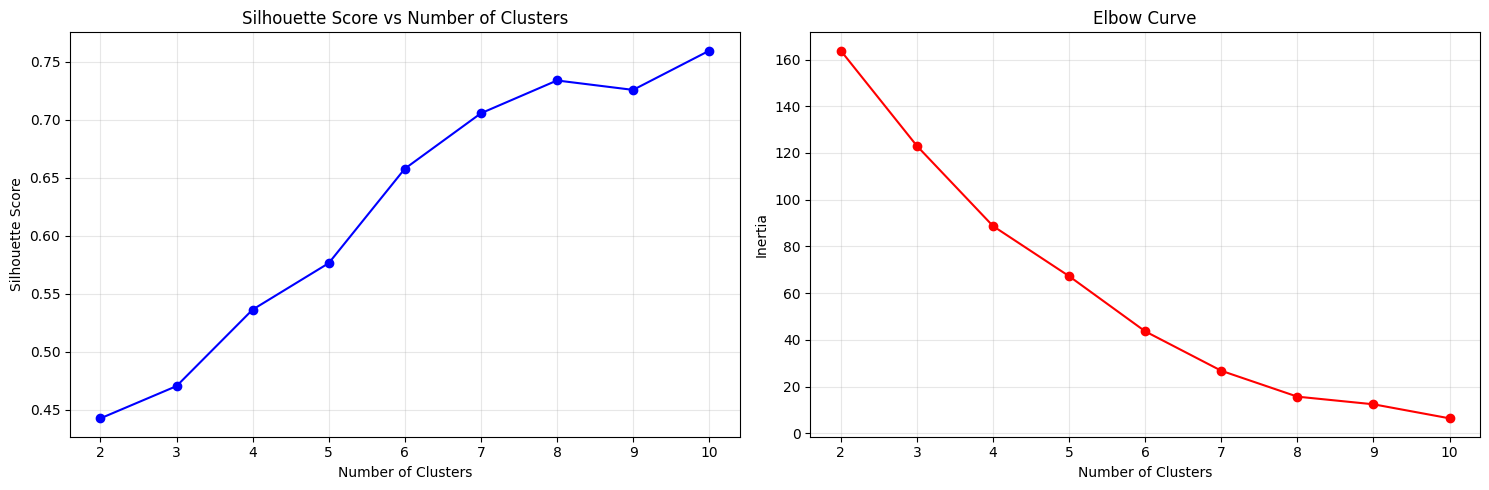

In [11]:
# Prepare the data
noise_profiles = school_patterns_df.groupby('DBN')[presence_cols].mean().reset_index()
scaler = StandardScaler()
noise_scaled = scaler.fit_transform(noise_profiles[presence_cols])

# Try range of 10 clusters
n_clusters_range = range(2, 11)
silhouette_scores = []
inertias = []  # For elbow method

for n_clusters in n_clusters_range:
    # Fit KMeans and get silhouette score
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(noise_scaled)
    silhouette_avg = silhouette_score(noise_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Get inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)

# Create subplot for both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot silhouette scores
ax1.plot(n_clusters_range, silhouette_scores, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs Number of Clusters')
ax1.grid(True, alpha=0.3)

# Plot elbow curve
ax2.plot(n_clusters_range, inertias, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Inertia')
ax2.set_title('Elbow Curve')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Based on our elbow curve graph, there is no distinctly identifiable "elbow." At $k=8$, however, the silhouette score begins to plateau.

In [12]:
# Print exact values of silhouette scores
print("Silhouette scores for each number of clusters:")
for n, score in zip(n_clusters_range, silhouette_scores):
    print(f"n_clusters={n}: {score:.3f}")

Silhouette scores for each number of clusters:
n_clusters=2: 0.443
n_clusters=3: 0.470
n_clusters=4: 0.536
n_clusters=5: 0.576
n_clusters=6: 0.658
n_clusters=7: 0.705
n_clusters=8: 0.734
n_clusters=9: 0.726
n_clusters=10: 0.759


To identify the best possible value of `k`, let's take a closer look at how our groups of schools are clustered:

In [13]:
# Print cluster sizes for each option
for n in n_clusters_range:
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(noise_scaled)
    print(f"Cluster sizes for n_clusters={n}:")
    sizes = pd.Series(labels).value_counts().sort_index()
    print(sizes)

total_schools = len(noise_profiles)
print(f"\nTotal number of schools: {total_schools}")

Cluster sizes for n_clusters=2:
0    15
1    24
Name: count, dtype: int64
Cluster sizes for n_clusters=3:
0    13
1     8
2    18
Name: count, dtype: int64
Cluster sizes for n_clusters=4:
0    13
1     8
2    16
3     2
Name: count, dtype: int64
Cluster sizes for n_clusters=5:
0     9
1     7
2    12
3     2
4     9
Name: count, dtype: int64
Cluster sizes for n_clusters=6:
0    7
1    7
2    9
3    2
4    9
5    5
Name: count, dtype: int64
Cluster sizes for n_clusters=7:
0    7
1    7
2    8
3    2
4    9
5    3
6    3
Name: count, dtype: int64
Cluster sizes for n_clusters=8:
0    7
1    8
2    7
3    2
4    1
5    2
6    3
7    9
Name: count, dtype: int64
Cluster sizes for n_clusters=9:
0    7
1    3
2    7
3    2
4    1
5    2
6    3
7    8
8    6
Name: count, dtype: int64
Cluster sizes for n_clusters=10:
0    7
1    3
2    7
3    2
4    1
5    2
6    3
7    7
8    6
9    1
Name: count, dtype: int64

Total number of schools: 39


Note that we begin to see our first single-school clusters at $k=8$. This is not desirable, so we will be choosing a $k$ such that $k < 8$.

At $k = 6$, we see fairly balanced clusters of schools. There is one group of 2, and all other clusters contain between 5 and 9 schools.

Cluster sizes for $k=7$ are less balanced, however. Because it is the most balanced, and since it has a strong silhouette score at 0.658, we will choose $k=6$.

### Noise characteristics heatmap for each cluster <a name="noise-cluster-heatmap"></a>

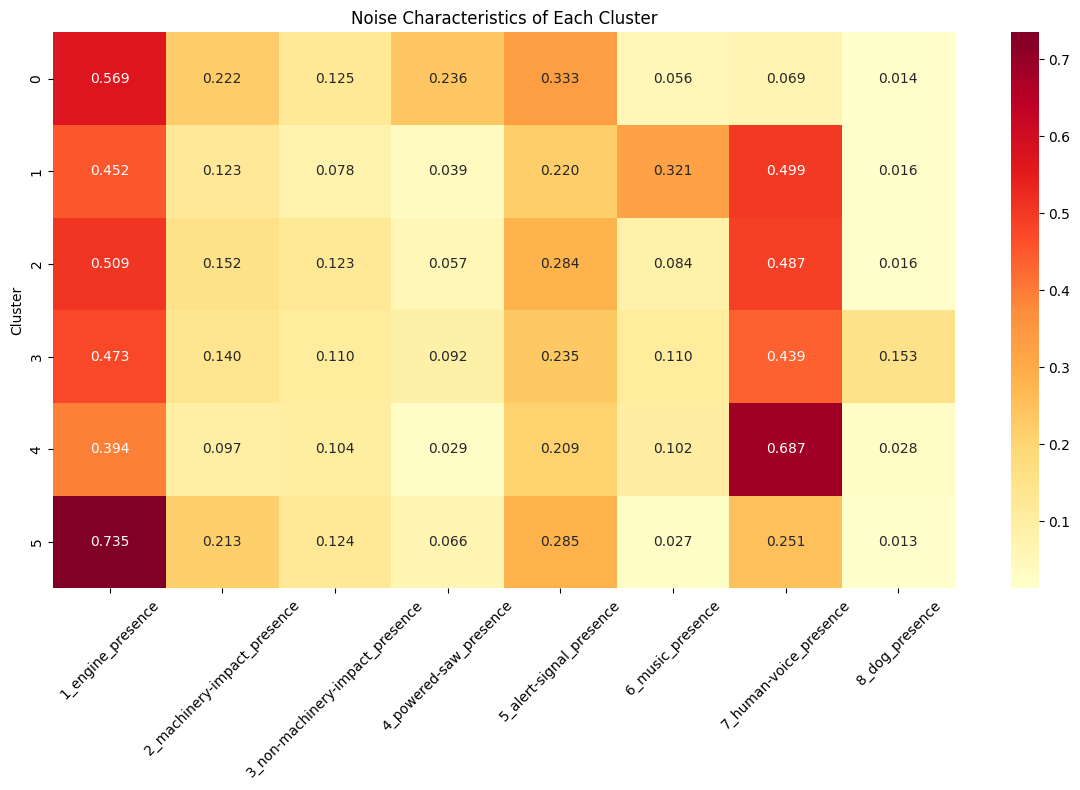

In [14]:
optimal_clusters = 6

# Perform final clustering with optimal number
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
noise_profiles['Cluster'] = kmeans_final.fit_predict(noise_scaled)

# Analyze cluster characteristics
# Create heatmap of cluster centers
plt.figure(figsize=(12, 8))
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans_final.cluster_centers_),
    columns=presence_cols
)
sns.heatmap(cluster_centers, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Noise Characteristics of Each Cluster')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Cluster sizes

In [26]:
# Print cluster sizes
print("Number of schools in each cluster:")
print(noise_profiles['Cluster'].value_counts())

Number of schools in each cluster:
Cluster
2    9
4    9
0    7
1    7
5    5
3    2
Name: count, dtype: int64


### Academic performance by cluster <a name="academic-performance"></a>

In [29]:
# Analyze academic performance by cluster
# Merge with achievement data
cluster_achievement = pd.merge(
    noise_profiles,
    pd.concat([
        combined_lg_achievement_df[['DBN', 'achievement_score', 'academic_year']],
        combined_hs_achievement_df[['DBN', 'achievement_score', 'academic_year']]
    ]),
    on='DBN'
)

# Calculate average achievement by cluster
print("Average achievement score by cluster:")
print(cluster_achievement.groupby('Cluster')['achievement_score'].mean())

Average achievement score by cluster:
Cluster
0    3.415556
1    3.294583
2    3.641875
3    4.216667
4    3.423793
5    4.007500
Name: achievement_score, dtype: float64


### Cluster visualization <a name="cluster-visualization"></a>

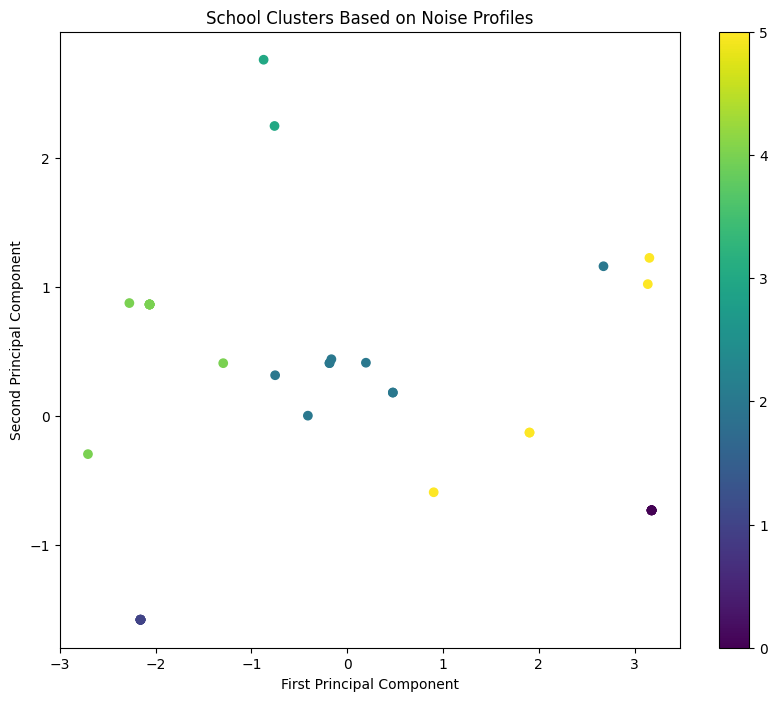

In [27]:
# Create visualization of clusters
# Use PCA to visualize in 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
noise_pca = pca.fit_transform(noise_scaled)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(noise_pca[:, 0], noise_pca[:, 1], 
                     c=noise_profiles['Cluster'], 
                     cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('School Clusters Based on Noise Profiles')
plt.colorbar(scatter)
plt.show()

### Feature importance <a name="feature-importance"></a>

In [16]:
# Show feature importance
print("Feature importance (PCA components):")
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=presence_cols
)
print(feature_importance)

Feature importance (PCA components):
                                      PC1       PC2
1_engine_presence                0.374221  0.025222
2_machinery-impact_presence      0.437334 -0.083197
3_non-machinery-impact_presence  0.331954  0.477936
4_powered-saw_presence           0.358770 -0.225246
5_alert-signal_presence          0.411877 -0.078699
6_music_presence                -0.296244 -0.531409
7_human-voice_presence          -0.403404  0.294488
8_dog_presence                  -0.098235  0.581354


#### First Principal Component (PC1)
**Strong positive correlations:**
- Machinery-impact (0.437)
- Alert-signal (0.412)
- Engine (0.374)
- Powered saw (0.359)

**Strong negative correlations:**
- Human voice (-0.403)
- Music (-0.296)

PC1 seems to separate mechanical noise from human-generated noise.

#### Second Principal Component (PC2):
**Strong positive correlations:**
- Dog (0.581)
- Non-machinery impact (0.478)
- Human voice (0.294)

**Strong negative correlations:**
- Music (-0.531)
- Powered saw (-0.225)

PC2 seems to separate uncontrolled environmental noise from intentional noise.

In [17]:
schoolpoints_gdf_coverage = schoolpoints_gdf[schoolpoints_gdf['ATS'].isin(filtered_schools)]

# First, rerun the clustering with 6 clusters
noise_profiles = school_patterns_df.groupby('DBN')[presence_cols].mean().reset_index()
scaler = StandardScaler()
noise_scaled = scaler.fit_transform(noise_profiles[presence_cols])
kmeans = KMeans(n_clusters=6, random_state=42)
noise_profiles['Cluster'] = kmeans.fit_predict(noise_scaled)

# Get the most recent academic year for each school
latest_lg = combined_lg_achievement_df.sort_values('academic_year').groupby('DBN').last().reset_index()
latest_hs = combined_hs_achievement_df.sort_values('academic_year').groupby('DBN').last().reset_index()

# 1. Schools in each cluster with their characteristics
# Merge with school information and achievement data
cluster_info = noise_profiles.merge(
    pd.concat([
        latest_lg[['DBN', 'school_name', 'achievement_score', 'grade_level']],
        latest_hs[['DBN', 'school_name', 'achievement_score', 'grade_level']]
    ]),
    on='DBN'
).merge(
    combined_summary_df.sort_values('academic_year').groupby('DBN').last().reset_index()[
        ['DBN', 'enrollment', 'ell_pct', 'disability_pct', 
         'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct']
    ],
    on='DBN'
)

# Print detailed cluster information
print("Detailed Cluster Information:")
for cluster in range(6):
    cluster_schools = cluster_info[cluster_info['Cluster'] == cluster]
    print(f"\nCluster {cluster} Schools:")
    print(f"Number of schools: {len(cluster_schools)}")
    print("\nSchools in this cluster:")
    for _, school in cluster_schools.iterrows():
        print(f"DBN: {school['DBN']}, Name: {school['school_name']}")
    print("\nCluster Characteristics:")
    print("Average Achievement Score:", cluster_schools['achievement_score'].mean())
    print("Grade Levels:", cluster_schools['grade_level'].value_counts().to_dict())
    print("\nDemographic Averages:")
    for col in ['enrollment', 'ell_pct', 'disability_pct', 'asian_pct', 
                'black_pct', 'hispanic_pct', 'white_pct']:
        print(f"{col}: {cluster_schools[col].mean():.2f}")

# Print total number of unique schools
print("\nVerification:")
print(f"Total unique schools: {len(cluster_info)}")
print(f"Schools per cluster:")
print(cluster_info['Cluster'].value_counts().sort_index())

Detailed Cluster Information:

Cluster 0 Schools:
Number of schools: 7

Schools in this cluster:
DBN: 02M135, Name: The Urban Assembly School for Emergency Management
DBN: 02M280, Name: Manhattan Early College School for Advertising
DBN: 02M282, Name: Urban Assembly Maker Academy
DBN: 02M343, Name: The Peck Slip School
DBN: 02M397, Name: Spruce Street School
DBN: 02M418, Name: Millennium High School
DBN: 02M520, Name: Murry Bergtraum High School for Business Careers

Cluster Characteristics:
Average Achievement Score: 3.3728571428571428
Grade Levels: {'hs': 5, 'lg': 2}

Demographic Averages:
enrollment: 414.00
ell_pct: 0.04
disability_pct: 0.19
asian_pct: 0.16
black_pct: 0.22
hispanic_pct: 0.33
white_pct: 0.23

Cluster 1 Schools:
Number of schools: 8

Schools in this cluster:
DBN: 13K350, Name: Urban Assembly School for Music and Art
DBN: 13K419, Name: Science Skills Center High School for Science, Tec
DBN: 13K439, Name: Brooklyn International High School
DBN: 13K483, Name: The Urban A

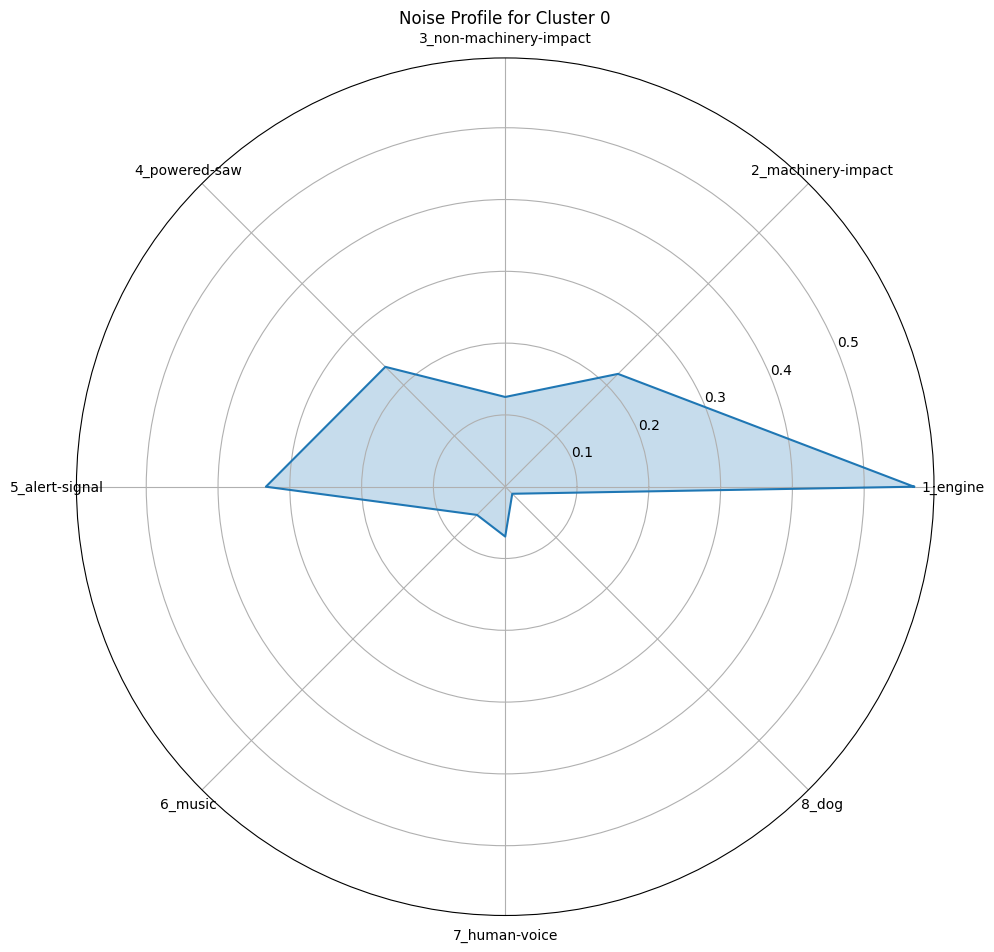

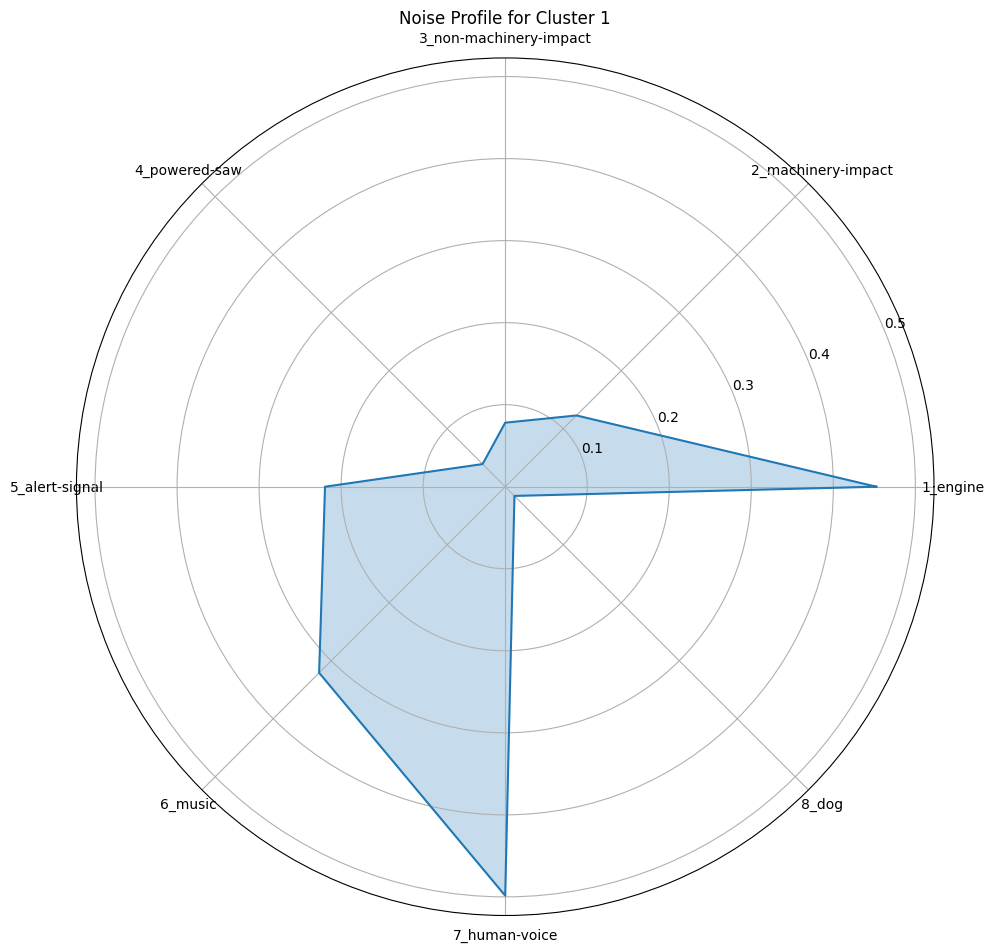

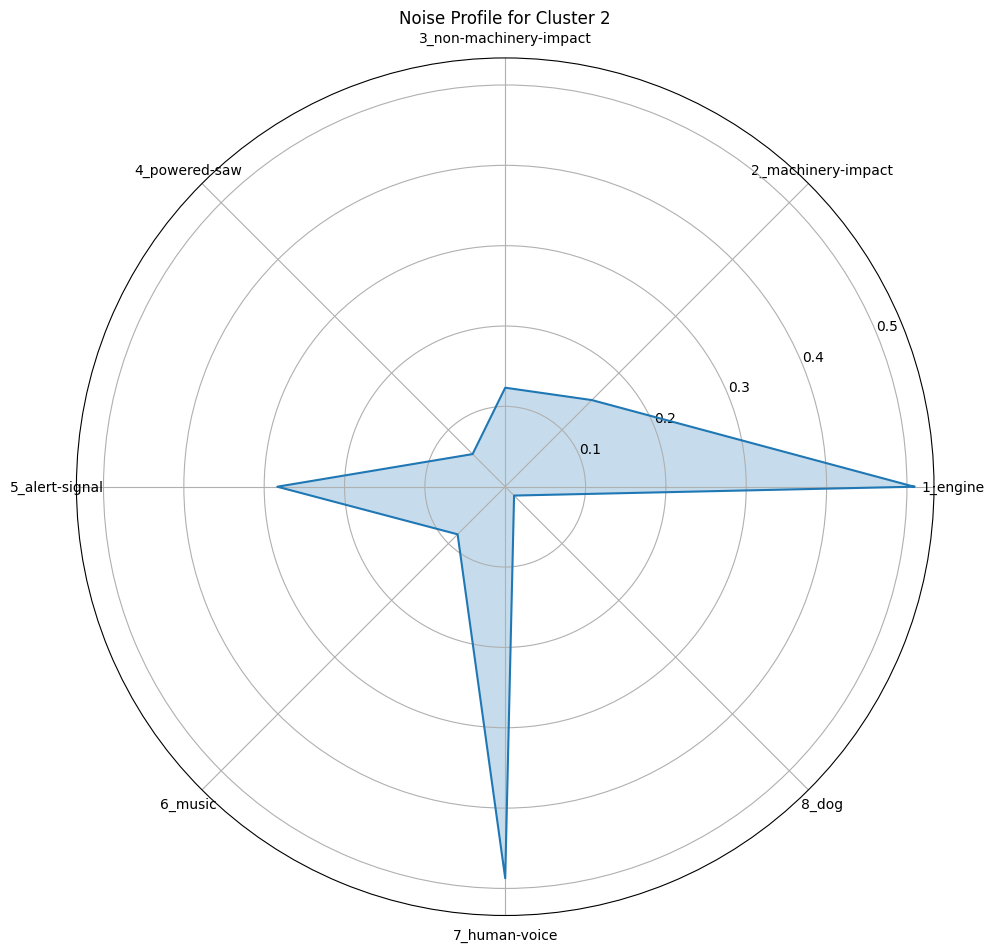

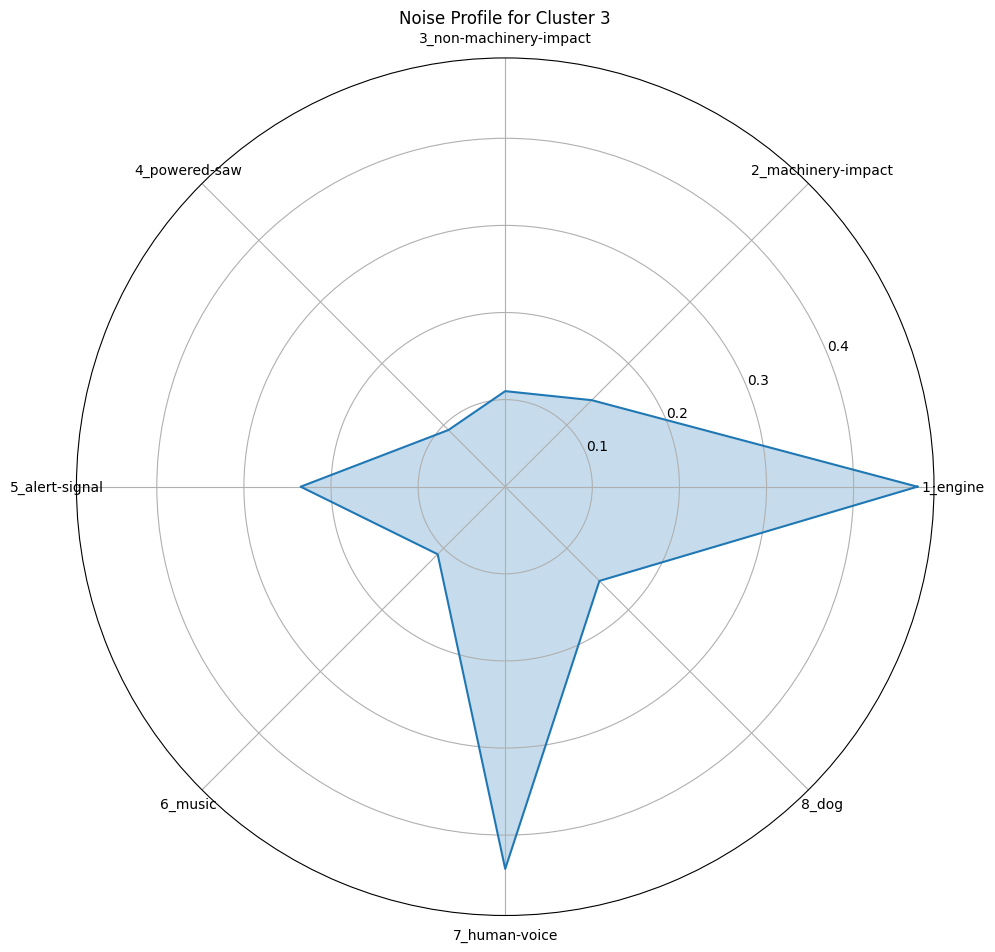

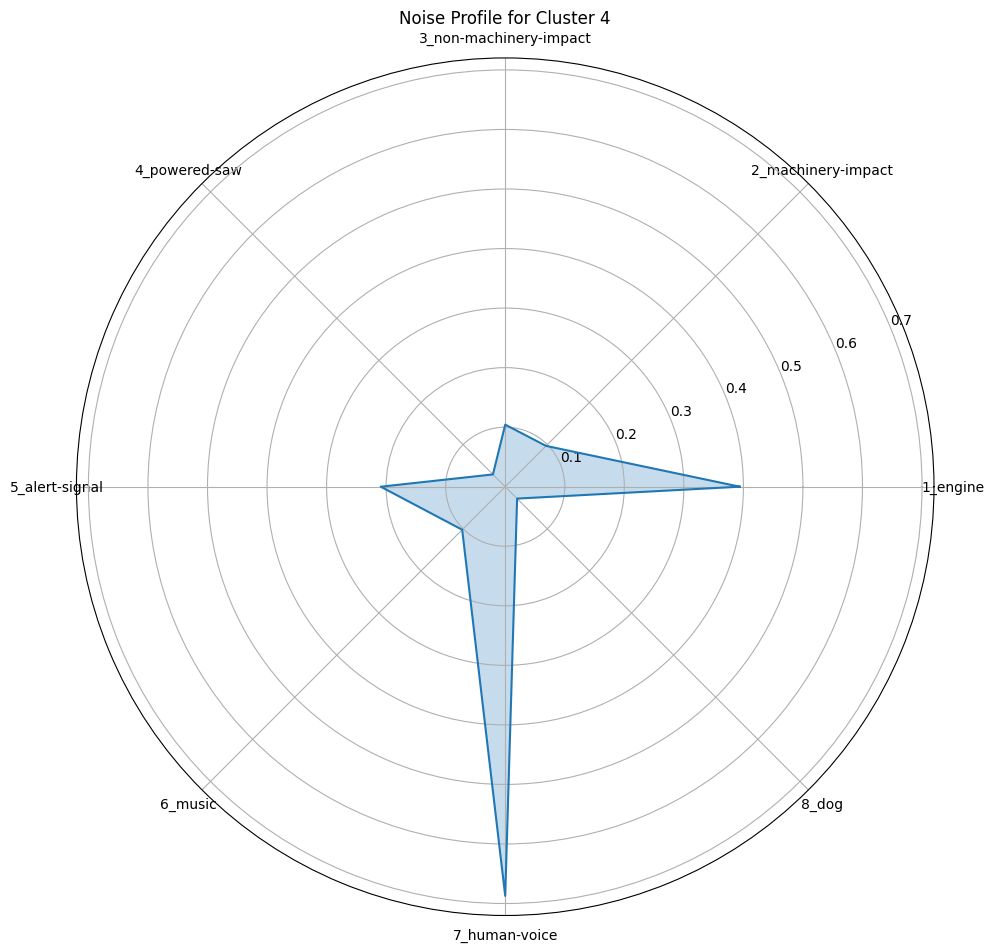

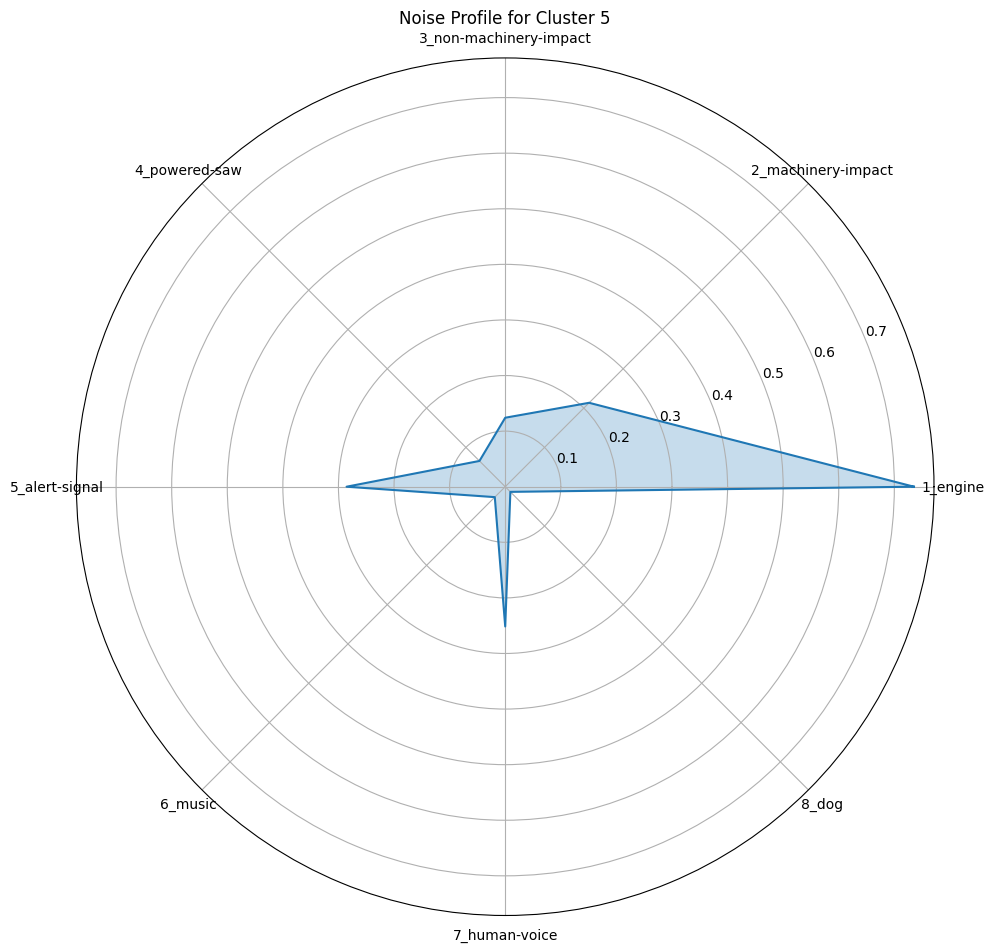

In [18]:
# 2. Cluster Characteristics Visualization
# Create radar chart of noise profiles for each cluster
def radar_chart(cluster_centers, cluster_num):
    categories = [col.replace('_presence', '') for col in presence_cols]
    values = cluster_centers.iloc[cluster_num].values  # Convert to numpy array
    
    # Create the plot
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    
    # Complete the circle using numpy array indexing
    values = np.append(values, values[0])  # Add first value to end
    angles = np.append(angles, angles[0])  # Add first angle to end
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, rotation=45)
    plt.title(f'Noise Profile for Cluster {cluster_num}')
    plt.tight_layout()
    plt.show()

# Create radar charts for each cluster
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=presence_cols
)

for i in range(6):
    radar_chart(cluster_centers, i)

In [19]:
# 3. Geographic Distribution
# Create map with clusters
center_lat = schoolpoints_gdf_coverage.geometry.y.mean()
center_lon = schoolpoints_gdf_coverage.geometry.x.mean()
m = folium.Map(location=[center_lat, center_lon], 
               tiles="Cartodb Positron", 
               zoom_start=11)

# Add district boundaries
districts_layer = folium.FeatureGroup(name='School Districts')
folium.GeoJson(
    districts_gdf,
    style_function=lambda x: {
        'fillColor': 'gray',
        'fillOpacity': 0.1,
        'color': 'black',
        'weight': 1
    },
    tooltip=folium.GeoJsonTooltip(fields=['school_dis'])
).add_to(districts_layer)
districts_layer.add_to(m)

# Add clusters to map
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred']
cluster_map_data = schoolpoints_gdf_coverage.copy()
cluster_map_data = cluster_map_data.rename(columns={'ATS': 'DBN'})
cluster_map_data = cluster_map_data.merge(noise_profiles[['DBN', 'Cluster']], on='DBN')

for idx, row in cluster_map_data.iterrows():
    popup_content = f"""
    <b>School:</b> {row['Name']}<br>
    <b>DBN:</b> {row['DBN']}<br>
    <b>Cluster:</b> {row['Cluster']}
    """
    
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=8,
        color=colors[row['Cluster']],
        fill=True,
        popup=folium.Popup(popup_content, max_width=300),
        tooltip=row['Name']
    ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed; 
    bottom: 50px; right: 50px; width: 150px; height: 180px; 
    border:2px solid grey; z-index:9999; background-color:white;
    opacity:0.8;
    padding: 10px;
    font-size: 12px;
    line-height: 1.2;">
    <p style="margin-top: 0; margin-bottom: 5px;"><b>Clusters</b></p>
"""
for i, color in enumerate(colors):
    legend_html += f'<p style="margin: 2px 0;"><span style="color:{color};">●</span> Cluster {i}</p>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(m)

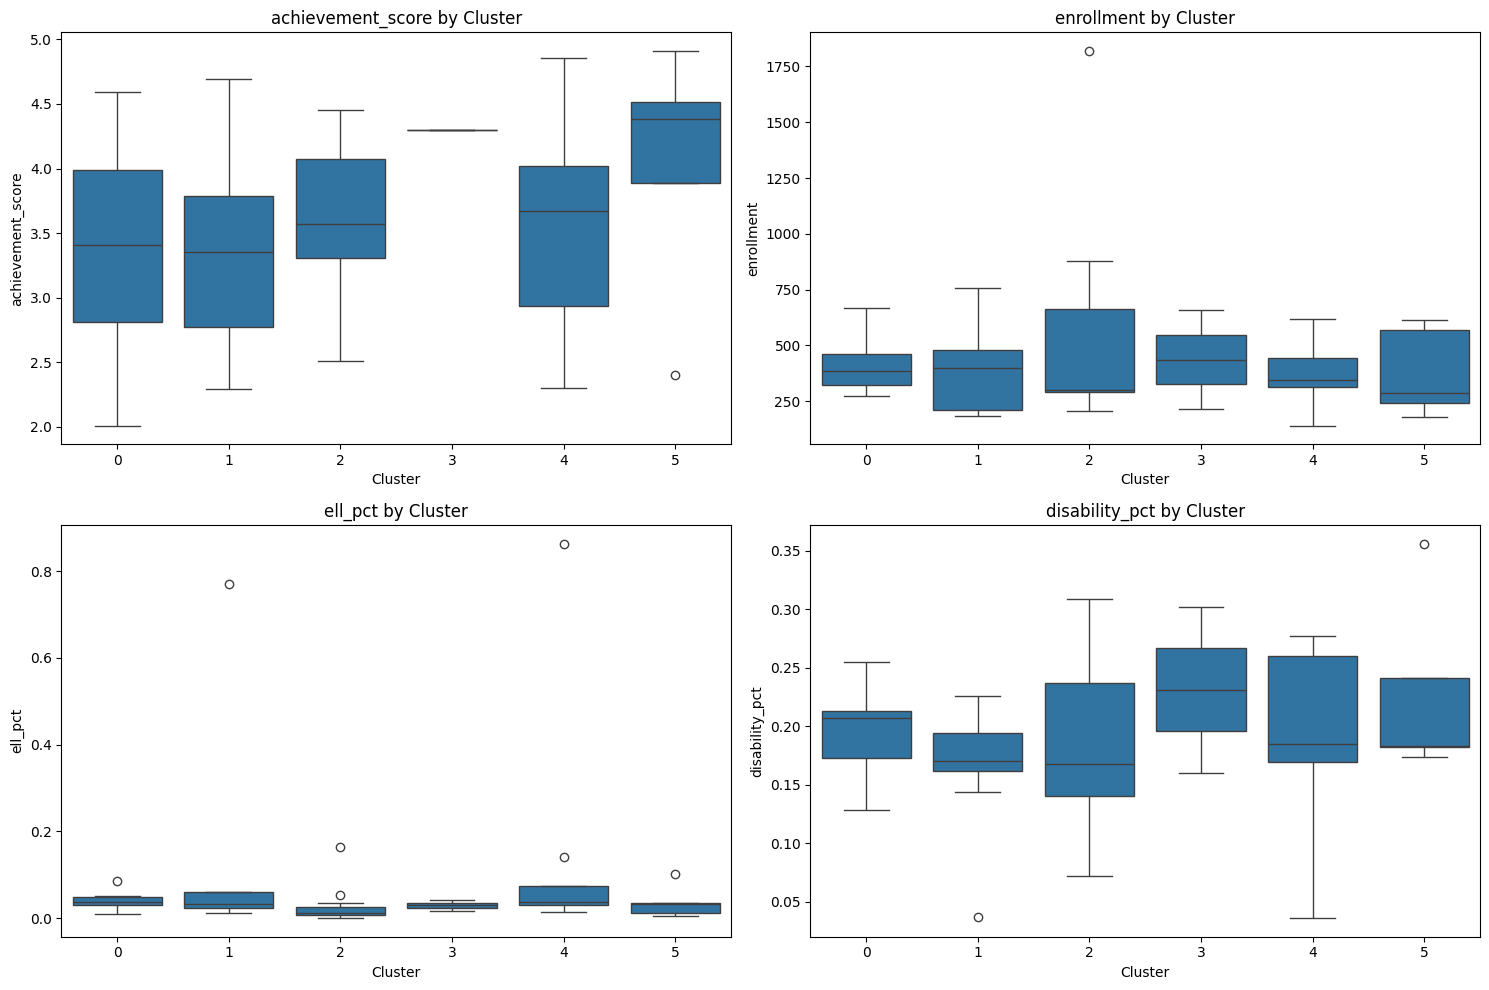


Statistical Summary by Cluster:

achievement_score averages by cluster:
Cluster
0    3.372857
1    3.340000
2    3.618182
3    4.300000
4    3.519000
5    4.017500
Name: achievement_score, dtype: float64

Standard deviation:
Cluster
0    0.905220
1    0.787147
2    0.596822
3         NaN
4    0.793073
5    1.106899
Name: achievement_score, dtype: float64

enrollment averages by cluster:
Cluster
0    414.000
1    393.125
2    534.500
3    436.500
4    358.600
5    377.600
Name: enrollment, dtype: float64

Standard deviation:
Cluster
0    139.133030
1    202.035667
2    459.012874
3    313.248304
4    144.129726
5    199.828176
Name: enrollment, dtype: float64

ell_pct averages by cluster:
Cluster
0    0.041000
1    0.125750
2    0.028167
3    0.029500
4    0.131000
5    0.036800
Name: ell_pct, dtype: float64

Standard deviation:
Cluster
0    0.023742
1    0.261379
2    0.045106
3    0.017678
4    0.260354
5    0.038790
Name: ell_pct, dtype: float64

disability_pct averages by cluster:


In [20]:
# 4. Statistical Analysis of Cluster Characteristics
# Create boxplots of key metrics by cluster
metrics = ['achievement_score', 'enrollment', 'ell_pct', 'disability_pct']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    sns.boxplot(data=cluster_info, x='Cluster', y=metric, ax=axes[idx])
    axes[idx].set_title(f'{metric} by Cluster')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary by Cluster:")
for metric in metrics:
    print(f"\n{metric} averages by cluster:")
    print(cluster_info.groupby('Cluster')[metric].mean())
    print("\nStandard deviation:")
    print(cluster_info.groupby('Cluster')[metric].std())